# Strategy Design, Implementation, and Backtesting

This notebook implements strategy design (point 3) and backtesting (point 4) for Group 1, as outlined in the action plan. We load the cleaned 1-min data and proceed with two entry/exit approaches, parameter sweeps, and performance evaluation.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## 1. Load Cleaned Data

Load the cleaned 1-minute data for SP and NQ from the Parquet file for further strategy development and backtesting.

In [3]:
# Load cleaned data


data_NQ_SP = pd.read_parquet('data/cleaned_summary_data1_all_quarters.parquet')

# Ensure DatetimeIndex (needed later for intraday rules like exit_time)
if not isinstance(data_NQ_SP.index, pd.DatetimeIndex):
    if 'datetime' in data_NQ_SP.columns:
        data_NQ_SP['datetime'] = pd.to_datetime(data_NQ_SP['datetime'])
        data_NQ_SP = data_NQ_SP.set_index('datetime').sort_index()
    else:
        raise ValueError("Data must have a DatetimeIndex or a 'datetime' column.")

print(data_NQ_SP.info())
data_NQ_SP.tail(30)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175812 entries, 2023-01-02 09:31:00+00:00 to 2025-06-30 16:00:00+00:00
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   close_NQ       166806 non-null  float64
 1   close_SP       166806 non-null  float64
 2   year_quarter   166806 non-null  object 
 3   date           175812 non-null  object 
 4   time           175812 non-null  object 
 5   r_NQ           166806 non-null  float64
 6   r_SP           166806 non-null  float64
 7   no_trade       175812 non-null  bool   
 8   signal_window  175812 non-null  bool   
dtypes: bool(2), float64(4), object(3)
memory usage: 11.1+ MB
None


,close_NQ,close_SP,year_quarter,date,time,r_NQ,r_SP,no_trade,signal_window
datetime,,,,,,,,,
2025-06-30 15:31:00+00:00,22650.608,6198.865,2025Q2,2025-06-30,15:31:00,-3.619998,-4.327275,False,False
2025-06-30 15:32:00+00:00,22657.731,6200.864,2025Q2,2025-06-30,15:32:00,3.144234,3.224264,False,False
2025-06-30 15:33:00+00:00,22656.131,6200.138,2025Q2,2025-06-30,15:33:00,-0.706186,-1.170873,False,False
2025-06-30 15:34:00+00:00,22663.297,6201.629,2025Q2,2025-06-30,15:34:00,3.162441,2.404496,False,False
2025-06-30 15:35:00+00:00,22662.576,6201.905,2025Q2,2025-06-30,15:35:00,-0.318141,0.445034,False,False
2025-06-30 15:36:00+00:00,22661.032,6201.185,2025Q2,2025-06-30,15:36:00,-0.681323,-1.161001,False,False
2025-06-30 15:37:00+00:00,22657.810,6199.494,2025Q2,2025-06-30,15:37:00,-1.421925,-2.727270,False,False
2025-06-30 15:38:00+00:00,22652.619,6197.311,2025Q2,2025-06-30,15:38:00,-2.291305,-3.521875,False,False
2025-06-30 15:39:00+00:00,22654.253,6197.338,2025Q2,2025-06-30,15:39:00,0.721303,0.043567,False,False


In [4]:
# Check which weekdays we have data for, showing weekday names
weekday_names = data_NQ_SP.index.strftime('%A')
print(weekday_names.value_counts())

# we dont have weekends, so we have only weekdays

datetime
Friday       35484
Thursday     35439
Tuesday      35362
Monday       34838
Wednesday    34689
Name: count, dtype: int64


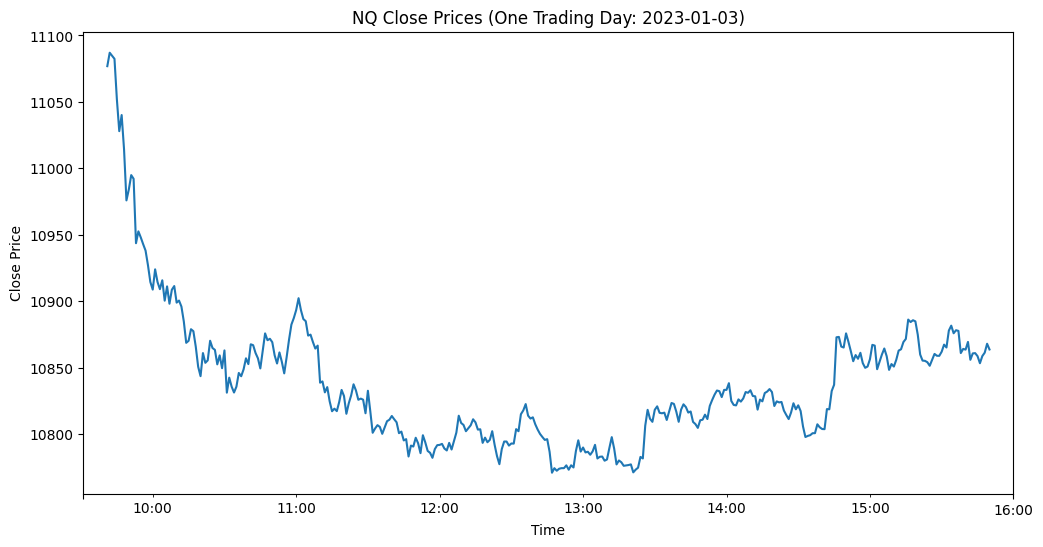

In [5]:
# Plot NQ close prices for one trading day


# Select the second trading day (first with valid close prices)
unique_days = np.unique(data_NQ_SP.index.date)
valid_days = [day for day in unique_days if data_NQ_SP.loc[data_NQ_SP.index.date == day]['close_NQ'].notna().sum() > 0]
if len(valid_days) < 2:
    raise ValueError("Not enough trading days with valid close prices.")
second_day = valid_days[1]
one_day = data_NQ_SP.loc[data_NQ_SP.index.date == second_day]

one_day['close_NQ'].plot(title=f'NQ Close Prices (One Trading Day: {second_day})', figsize=(12, 6))
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()


## 2. Strategy Design and Backtesting Framework

We design and backtest two entry/exit approaches on the cleaned 1-minute data for both **NQ** and **SP**:

- **Strategy 1: Moving Average (EMA) Crossover**
- **Strategy 2: Volatility Breakout**

For each strategy, we define a grid of parameter combinations and evaluate performance **by quarter** (in-sample), aggregating minute P&L to **daily** results. We report:

- **Gross/net Sharpe ratio (SR)**
- **Gross/net Calmar ratio (CR)**
- **Gross/net cumulative P&L**
- **Average daily trades**

**Summary statistic (used for ranking across quarters):**

    stat = (netSR − 0.5) * max(0, log(|net.PnL / 1000|))


In [6]:
# Define contract specifications for NQ and SP
# Each contract has:
# - symbol: column name for close price in the DataFrame
# - tcost: transaction cost per trade (in USD)
# - ptval: point value (USD per index point)
contracts = {
    "NQ": {"symbol": "close_NQ", "tcost": 12, "ptval": 20},
    "SP": {"symbol": "close_SP", "tcost": 12, "ptval": 50},
}

In [7]:
INSAMPLE_PERIODS = [p for p in data_NQ_SP["year_quarter"].unique() if p not in ("None", "nan", "", "NaT")]

In [8]:
# -----------------------------
# Helpers (define once)
# -----------------------------
def mySR(x: pd.Series, scale: int = 252) -> float:
    x = pd.Series(x).astype(float)
    mu = np.nanmean(x)
    sd = np.nanstd(x)
    return float(np.sqrt(scale) * mu / sd) if sd > 0 else np.nan

def calmar_from_daily_pnl(daily_pnl: pd.Series) -> float:
    """
    Calmar = annualized mean daily PnL / max drawdown of cum PnL (monetary)
    """
    daily_pnl = pd.Series(daily_pnl).fillna(0.0).astype(float)
    eq = daily_pnl.cumsum()
    dd = eq - eq.cummax()
    max_dd = float((-dd).max())
    ann_mean = float(daily_pnl.mean() * 252)
    return ann_mean / max_dd if max_dd > 0 else np.nan

def quarter_stat(net_sr: float, net_pnl: float, denom: float = 1000.0) -> float:
    """
    stat = (netSR − 0.5) * max(0, log(abs(netPnL/denom)))
    """
    if net_pnl == 0 or np.isnan(net_pnl) or np.isnan(net_sr):
        return 0.0
    return float((net_sr - 0.5) * max(0.0, np.log(abs(net_pnl / denom))))

### Strategy 2.1: Moving Average (EMA) Crossover

We implement a classic **dual EMA crossover** strategy on 1-minute data for both **NQ** and **SP** contracts.

### Indicators

- **Fast EMA:**  
    $$\text{fastEMA}_t = \text{EMA}(\text{price},\;\text{fastEMA})$$

- **Slow EMA:**  
    $$\text{slowEMA}_t = \text{EMA}(\text{price},\;\text{slowEMA})$$

### Trading Rules

We implement **two variations** of the crossover signal:

- **Momentum (MOM):**  
    - **Long** if $\text{fastEMA}_{t-1} > \text{slowEMA}_{t-1}$  
    - **Short** if $\text{fastEMA}_{t-1} < \text{slowEMA}_{t-1}$  
    - Positions are **lagged by 1 bar** to avoid lookahead bias.

- **Mean-Reversion (MR):**  
    - Take the **opposite** position of MOM (contrarian to the trend signal).


In [9]:


# -----------------------------
# Parameter grids + contracts
# -----------------------------
fastEMA_parameters = [15, 20, 30, 45, 60, 75]
slowEMA_parameters = [90, 120, 150, 180, 240, 300, 360]



data_NQ_SP["year_quarter"] = data_NQ_SP["year_quarter"].astype(str)

# -----------------------------
# Sweep (per quarter, per contract, per (fast,slow))
# -----------------------------
summary_rows = []

for period, df_q in data_NQ_SP.groupby("year_quarter", sort=True):
    if df_q.empty or period in ("None", "nan", "", "NaT"):
        continue

    for contract, params in contracts.items():
        price = df_q[params["symbol"]]
        pos_flat = df_q["no_trade"].astype(int) if "no_trade" in df_q.columns else 0

        for fastEMA in fastEMA_parameters:
            for slowEMA in slowEMA_parameters:
                if fastEMA >= slowEMA:
                    continue

                # EMAs
                fastEMA_values = price.ewm(span=fastEMA).mean()
                slowEMA_values = price.ewm(span=slowEMA).mean()
                fastEMA_values[price.isna()] = np.nan
                slowEMA_values[price.isna()] = np.nan

                # Signal (t-1, no lookahead)
                cond_long = fastEMA_values.shift(1) > slowEMA_values.shift(1)
                ok = fastEMA_values.shift(1).notna() & slowEMA_values.shift(1).notna()

                pos_mom = np.where(ok, np.where(cond_long, 1.0, -1.0), 0.0)
                pos_mr = -pos_mom

                # Flatten when not allowed
                if isinstance(pos_flat, pd.Series):
                    pos_mom[pos_flat.to_numpy() == 1] = 0.0
                    pos_mr[pos_flat.to_numpy() == 1] = 0.0

                # Trades (use MOM position changes; MR same turnover)
                ntrans = np.abs(np.diff(pos_mom, prepend=0.0))

                # Minute PnL (monetary)
                dpx = price.diff().fillna(0.0).to_numpy()
                pnl_gross_mom = pos_mom * dpx * params["ptval"]
                pnl_gross_mr  = pos_mr  * dpx * params["ptval"]

                pnl_net_mom = pnl_gross_mom - ntrans * params["tcost"]
                pnl_net_mr  = pnl_gross_mr  - ntrans * params["tcost"]

                # Daily aggregation
                idx = price.index
                pnl_gross_mom_d = pd.Series(pnl_gross_mom, index=idx).groupby(idx.date).sum()
                pnl_net_mom_d   = pd.Series(pnl_net_mom,   index=idx).groupby(idx.date).sum()

                pnl_gross_mr_d  = pd.Series(pnl_gross_mr,  index=idx).groupby(idx.date).sum()
                pnl_net_mr_d    = pd.Series(pnl_net_mr,    index=idx).groupby(idx.date).sum()

                ntrans_d = pd.Series(ntrans, index=idx).groupby(idx.date).sum()

                # Metrics (MOM)
                gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
                net_SR_mom   = mySR(pnl_net_mom_d,   scale=252)
                gross_CR_mom = calmar_from_daily_pnl(pnl_gross_mom_d)
                net_CR_mom   = calmar_from_daily_pnl(pnl_net_mom_d)
                gross_PnL_mom = float(pnl_gross_mom_d.sum())
                net_PnL_mom   = float(pnl_net_mom_d.sum())
                stat_mom      = quarter_stat(net_SR_mom, net_PnL_mom, denom=1000.0)

                # Metrics (MR)
                gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
                net_SR_mr   = mySR(pnl_net_mr_d,   scale=252)
                gross_CR_mr = calmar_from_daily_pnl(pnl_gross_mr_d)
                net_CR_mr   = calmar_from_daily_pnl(pnl_net_mr_d)
                gross_PnL_mr = float(pnl_gross_mr_d.sum())
                net_PnL_mr   = float(pnl_net_mr_d.sum())
                stat_mr      = quarter_stat(net_SR_mr, net_PnL_mr, denom=1000.0)

                av_daily_ntrans = float(ntrans_d.mean())

                summary_rows.append({
                    "contract": contract,
                    "fastEMA": int(fastEMA),
                    "slowEMA": int(slowEMA),
                    "period": period,

                    "gross_SR_mom": gross_SR_mom,
                    "net_SR_mom": net_SR_mom,
                    "gross_CR_mom": gross_CR_mom,
                    "net_CR_mom": net_CR_mom,
                    "gross_PnL_mom": gross_PnL_mom,
                    "net_PnL_mom": net_PnL_mom,
                    "stat_mom": stat_mom,

                    "gross_SR_mr": gross_SR_mr,
                    "net_SR_mr": net_SR_mr,
                    "gross_CR_mr": gross_CR_mr,
                    "net_CR_mr": net_CR_mr,
                    "gross_PnL_mr": gross_PnL_mr,
                    "net_PnL_mr": net_PnL_mr,
                    "stat_mr": stat_mr,

                    "av_daily_ntrans": av_daily_ntrans,
                })

summary_all_2MAs = pd.DataFrame(summary_rows)
display(summary_all_2MAs.head())

,contract,fastEMA,slowEMA,period,gross_SR_mom,net_SR_mom,gross_CR_mom,net_CR_mom,gross_PnL_mom,net_PnL_mom,stat_mom,gross_SR_mr,net_SR_mr,gross_CR_mr,net_CR_mr,gross_PnL_mr,net_PnL_mr,stat_mr,av_daily_ntrans
0,NQ,15,90,2023Q1,1.839900,1.104673,6.038628,2.967742,19524.92,11928.92,1.498963,-1.839900,-2.600456,-2.506500,-2.917149,-19524.92,-27120.92,-10.232450,9.738462
1,NQ,15,120,2023Q1,1.582887,0.973274,6.408549,3.535478,16781.64,10505.64,1.113098,-1.582887,-2.214319,-2.637975,-3.034038,-16781.64,-23057.64,-8.517526,8.046154
2,NQ,15,150,2023Q1,1.402476,0.836339,5.156754,3.002470,14807.64,8987.64,0.738551,-1.402476,-1.988642,-2.651849,-3.050206,-14807.64,-20627.64,-7.532203,7.461538
3,NQ,15,180,2023Q1,1.298496,0.736154,4.687278,2.625395,13110.76,7554.76,0.477545,-1.298496,-1.879041,-2.805415,-3.112092,-13110.76,-18666.76,-6.962846,7.123077
4,NQ,15,240,2023Q1,-0.314494,-0.839528,-0.993364,-2.057862,-3103.96,-8419.96,-2.854004,0.314494,-0.227739,0.960891,-0.663526,3103.96,-2212.04,-0.577763,6.815385


In [10]:
s = summary_all_2MAs.copy()
s = s[~s["period"].isin(["None", "nan", "", "NaT"])].copy()

s_is = s[s["period"].isin(INSAMPLE_PERIODS)].copy()
if s_is.empty:
    raise ValueError("No rows matched INSAMPLE_PERIODS. Check labels vs summary_all_2MAs['period'].")

# Require strategy exists in all in-sample quarters per contract
nq_is_by_contract = s_is.groupby("contract")["period"].nunique()

def pick_best_side_and_params(s_in: pd.DataFrame) -> pd.DataFrame:
    out = []
    for side, stat_col in [("mom", "stat_mom"), ("mr", "stat_mr")]:
        agg = (
            s_in.groupby(["contract", "fastEMA", "slowEMA"], as_index=False)
                .agg(
                    n_quarters=("period", "nunique"),
                    sum_stat=(stat_col, "sum"),
                    mean_turnover=("av_daily_ntrans", "mean"),
                )
        )
        agg["total_is_quarters_contract"] = agg["contract"].map(nq_is_by_contract)
        agg = agg[agg["n_quarters"] == agg["total_is_quarters_contract"]].copy()

        # Primary objective: maximize sum(stat) in-sample; tiny turnover penalty to break ties
        agg["score"] = agg["sum_stat"] - 0.001 * agg["mean_turnover"].fillna(0.0)
        agg["side"] = side
        out.append(agg)

    best_both = pd.concat(out, ignore_index=True)
    best_choice = (
        best_both.sort_values(["contract", "score"], ascending=[True, False])
                 .groupby("contract", as_index=False)
                 .head(1)
                 .reset_index(drop=True)
    )
    return best_choice

best_choice = pick_best_side_and_params(s_is)
display(best_choice)

# -----------------------------
# 2) Build FINAL per-quarter report table from the sweep output (frozen params)
# -----------------------------
rows = []
for _, r in best_choice.iterrows():
    c = r["contract"]
    fast = int(r["fastEMA"])
    slow = int(r["slowEMA"])
    side = r["side"]

    sub = s[(s["contract"] == c) & (s["fastEMA"] == fast) & (s["slowEMA"] == slow)].copy()

    if side == "mom":
        sub_out = pd.DataFrame({
            "period": sub["period"],
            "contract": sub["contract"],
            "strategy": "EMA_crossover_mom",
            "fastEMA": sub["fastEMA"],
            "slowEMA": sub["slowEMA"],
            "gross_SR": sub["gross_SR_mom"],
            "net_SR": sub["net_SR_mom"],
            "gross_CR": sub["gross_CR_mom"],
            "net_CR": sub["net_CR_mom"],
            "gross_cumPnL": sub["gross_PnL_mom"],
            "net_cumPnL": sub["net_PnL_mom"],
            "av_ntrades": sub["av_daily_ntrans"],
            "stat": sub["stat_mom"],
        })
    else:
        sub_out = pd.DataFrame({
            "period": sub["period"],
            "contract": sub["contract"],
            "strategy": "EMA_crossover_mr",
            "fastEMA": sub["fastEMA"],
            "slowEMA": sub["slowEMA"],
            "gross_SR": sub["gross_SR_mr"],
            "net_SR": sub["net_SR_mr"],
            "gross_CR": sub["gross_CR_mr"],
            "net_CR": sub["net_CR_mr"],
            "gross_cumPnL": sub["gross_PnL_mr"],
            "net_cumPnL": sub["net_PnL_mr"],
            "av_ntrades": sub["av_daily_ntrans"],
            "stat": sub["stat_mr"],
        })

    rows.append(sub_out)

final_summary_table = (
    pd.concat(rows, ignore_index=True)
      .sort_values(["contract", "period"])
      .reset_index(drop=True)
)

display(final_summary_table)

# # Save as CSV (required)
final_summary_table.to_csv("data/group1_final_summary_table_2EMA_crossover.csv", index=False)

# Optional totals
display(final_summary_table.groupby("contract")["stat"].sum())
display(pd.DataFrame({"TOTAL_STAT_ALL_CONTRACTS": [final_summary_table["stat"].sum()]}))

,contract,fastEMA,slowEMA,n_quarters,sum_stat,mean_turnover,total_is_quarters_contract,score,side
0,NQ,20,360,7,-1.062139,5.525493,7,-1.067665,mom
1,SP,45,240,7,-3.973537,4.996855,7,-3.978534,mom


,period,contract,strategy,fastEMA,slowEMA,gross_SR,net_SR,gross_CR,net_CR,gross_cumPnL,net_cumPnL,av_ntrades,stat
0,2023Q1,NQ,EMA_crossover_mom,20,360,0.307937,-0.071004,0.738163,-0.148879,3278.60,-765.40,5.184615,-0.000000
1,2023Q3,NQ,EMA_crossover_mom,20,360,1.342339,0.877275,3.154049,1.920455,12349.28,8161.28,5.369231,0.792051
2,2023Q4,NQ,EMA_crossover_mom,20,360,1.666333,1.150732,4.926490,3.176302,14794.36,10390.36,5.734375,1.523284
3,2024Q2,NQ,EMA_crossover_mom,20,360,0.013860,-0.423232,0.034332,-0.983334,151.44,-4684.56,6.200000,-1.425721
4,2024Q4,NQ,EMA_crossover_mom,20,360,0.271250,-0.133193,0.726160,-0.342591,3153.84,-1562.16,6.046154,-0.282448
5,2025Q1,NQ,EMA_crossover_mom,20,360,0.026019,-0.271231,0.037564,-0.373846,307.66,-3232.34,4.682540,-0.904814
6,2025Q2,NQ,EMA_crossover_mom,20,360,0.038597,-0.136533,0.073841,-0.243849,936.48,-3323.52,5.461538,-0.764492
7,2023Q1,SP,EMA_crossover_mom,45,240,0.253242,-0.220719,0.520585,-0.416754,1918.65,-1693.35,4.630769,-0.379609
8,2023Q3,SP,EMA_crossover_mom,45,240,1.217750,0.297494,2.848403,0.649188,5435.40,1367.40,5.215385,-0.063366
9,2023Q4,SP,EMA_crossover_mom,45,240,1.096078,0.258073,4.125287,0.832159,5199.80,1251.80,5.140625,-0.054333


contract
NQ   -1.062139
SP   -3.973537
Name: stat, dtype: float64

,TOTAL_STAT_ALL_CONTRACTS
0,-5.035676


---

### Performance summary

Overall, the strategy’s performance is inconsistent across quarters. While there are isolated strong quarters (e.g., **NQ in 2023Q3–2023Q4** and **SP in 2024Q4**, where net Sharpe is positive and the summary statistic is high), many quarters have **negative net Sharpe** and **negative net cumulative P&L**, indicating that after transaction costs the strategy often fails to deliver positive risk-adjusted returns.

This suggests **regime dependence**:

- EMA crossovers tend to perform well in sustained trends.
- They can lose money during sideways/mean-reverting periods, where frequent signal flips increase turnover and cost drag.

---

#### Which statistics we focus on 

To judge whether the strategy is “good” for this task, the primary metrics are:

- **`net_SR`** (annualized Sharpe on daily net P&L): the key risk-adjusted metric after costs.  
- **`net_cumPnL`** (net cumulative P&L): the profitability metric after costs.  
- **`stat`** (assignment summary statistic):

$$
\text{stat} = (\text{net\_SR} - 0.5)\,\max\!\left(0,\ \ln\!\left(\left|\frac{\text{netPnL}}{1000}\right|\right)\right)
$$

This is the metric that is **summed across quarters for ranking**, so sustained positive `stat` matters more than a few strong quarters.

#### Secondary diagnostics

- **`net_CR`** (net Calmar ratio) to assess return vs. drawdown characteristics.
- **Gross vs. net differences** (e.g., `gross_SR` vs. `net_SR`) to quantify transaction-cost sensitivity.
- **`av_ntrades`** to understand turnover and cost exposure.

---

#### Conclusion

Despite some strong quarters, the strategy is not robust because it produces **negative net Sharpe** and **negative net P&L** in multiple quarters, leading to **negative/low `stat`** in many periods.

For a stronger submission, we would typically seek either:

1. A strategy with more stable positive `net_SR` across quarters, **or**
2. Additional filters/rules (e.g., trend/volatility regime filter or reduced trading frequency) to reduce churn and improve net performance consistency.

### Strategy 2.2: Volatility Breakout (fast EMA signal + volatility bands)

We trade breakouts using a **fast EMA** as the trigger and **volatility bands** around a **slow EMA** as the range.

**Indicators**

- **Signal (fast EMA):**  
    $$sEMA_t = \text{EMA}(\text{price},\;\text{signalEMA})$$

- **Center (slow EMA):**  
    $$lEMA_t = \text{EMA}(\text{price},\;\text{slowEMA})$$

- **Volatility (rolling std):**  
    $$vSD_t = \text{Std}(\text{price},\;\text{volat\_sd})$$

- **Bands:**  
    $$U_t = lEMA_t + m \cdot vSD_t, \quad L_t = lEMA_t - m \cdot vSD_t$$

**Trading rule**
- **Momentum (MOM):**  
    - Long if \(sEMA_t > U_t\)  
    - Short if \(sEMA_t < L_t\)  
    - Otherwise flat  
    Positions are **lagged by 1 bar** to avoid lookahead.
- **Mean-reversion (MR):** take the **opposite** position of MOM.

We sweep \((signalEMA,\;slowEMA,\;volat\_sd,\;m)\) **by quarter** and compute SR/CR/cumPnL/trades and the assignment **`stat`**.

In [12]:
# -----------------------------
# Volatility breakout sweep (per quarter, per contract, per (signalEMA, slowEMA, volat_sd, m))
# -----------------------------

# Use the same helper as the lab notebook.
# IMPORTANT: `positionVB` already uses (t-1) signal/bands to set position at t,
# so do NOT apply an additional shift/lag here.
from functions.position_VB import positionVB

# Parameter grid (feel free to adjust, but keep fixed once selected)
signalEMA_parameters = [10,20, 45, 60,75 ,90]
slowEMA_parameters = [90, 120, 150, 180, 240]
volat_sd_parameters = [30, 60, 90]
m_parameters = [1, 2, 3]

summary_rows_vb = []

for period, df_q in data_NQ_SP.groupby("year_quarter", sort=True):
    # skip missing/invalid period labels
    if period is None or (isinstance(period, float) and np.isnan(period)):
        continue
    period_str = str(period)
    if period_str.strip().lower() in ("none", "nan", "nat", ""):
        continue
    if df_q.empty:
        continue

    for contract, params in contracts.items():
        price = df_q[params["symbol"]]
        pos_flat = df_q["no_trade"].astype(int) if "no_trade" in df_q.columns else 0

        pos_flat_np = (
            pos_flat.to_numpy(dtype=float)
            if isinstance(pos_flat, pd.Series)
            else np.zeros(len(price), dtype=float)
        )

        for signalEMA in signalEMA_parameters:
            print(f"signalEMA = {signalEMA}")
            for slowEMA in slowEMA_parameters:
                if signalEMA >= slowEMA:
                    continue

                # fast EMA (signal) and slow EMA (center)
                minp_fast = max(1, int(signalEMA) // 2)
                minp_slow = max(1, int(slowEMA) // 2)
                sEMA = price.ewm(span=int(signalEMA), min_periods=minp_fast, adjust=False).mean()
                lEMA = price.ewm(span=int(slowEMA), min_periods=minp_slow, adjust=False).mean()
                sEMA[price.isna()] = np.nan
                lEMA[price.isna()] = np.nan

                for volat_sd in volat_sd_parameters:
                    minp_sd = max(1, int(volat_sd) // 2)
                    vSD = price.rolling(window=int(volat_sd), min_periods=minp_sd).std()
                    vSD[price.isna()] = np.nan

                    for m in m_parameters:
                        upper = lEMA + float(m) * vSD
                        lower = lEMA - float(m) * vSD

                        # Positions from lab helper
                        pos_mom = np.asarray(
                            positionVB(
                                signal=sEMA.to_numpy(),
                                lower=lower.to_numpy(),
                                upper=upper.to_numpy(),
                                pos_flat=pos_flat_np,
                                strategy="mom",
                            ),
                            dtype=float,
                        )
                        pos_mr = np.asarray(
                            positionVB(
                                signal=sEMA.to_numpy(),
                                lower=lower.to_numpy(),
                                upper=upper.to_numpy(),
                                pos_flat=pos_flat_np,
                                strategy="mr",
                            ),
                            dtype=float,
                        )

                        pos_mom = np.nan_to_num(pos_mom, nan=0.0)
                        pos_mr = np.nan_to_num(pos_mr, nan=0.0)

                        # trades (use MOM position changes; MR same turnover)
                        ntrans = np.abs(np.diff(pos_mom, prepend=0.0))

                        # minute PnL (monetary)
                        dpx = price.diff().fillna(0.0).to_numpy()
                        pnl_gross_mom = pos_mom * dpx * params["ptval"]
                        pnl_gross_mr  = pos_mr  * dpx * params["ptval"]

                        pnl_net_mom = pnl_gross_mom - ntrans * params["tcost"]
                        pnl_net_mr  = pnl_gross_mr  - ntrans * params["tcost"]

                        # daily aggregation
                        idx = price.index
                        pnl_gross_mom_d = pd.Series(pnl_gross_mom, index=idx).groupby(idx.date).sum()
                        pnl_net_mom_d   = pd.Series(pnl_net_mom,   index=idx).groupby(idx.date).sum()
                        pnl_gross_mr_d  = pd.Series(pnl_gross_mr,  index=idx).groupby(idx.date).sum()
                        pnl_net_mr_d    = pd.Series(pnl_net_mr,    index=idx).groupby(idx.date).sum()
                        ntrans_d        = pd.Series(ntrans,        index=idx).groupby(idx.date).sum()

                        # MOM metrics
                        gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
                        net_SR_mom   = mySR(pnl_net_mom_d,   scale=252)
                        gross_CR_mom = calmar_from_daily_pnl(pnl_gross_mom_d)
                        net_CR_mom   = calmar_from_daily_pnl(pnl_net_mom_d)
                        gross_PnL_mom = float(pnl_gross_mom_d.sum())
                        net_PnL_mom   = float(pnl_net_mom_d.sum())
                        stat_mom      = quarter_stat(net_SR_mom, net_PnL_mom, denom=1000.0)

                        # MR metrics
                        gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
                        net_SR_mr   = mySR(pnl_net_mr_d,   scale=252)
                        gross_CR_mr = calmar_from_daily_pnl(pnl_gross_mr_d)
                        net_CR_mr   = calmar_from_daily_pnl(pnl_net_mr_d)
                        gross_PnL_mr = float(pnl_gross_mr_d.sum())
                        net_PnL_mr   = float(pnl_net_mr_d.sum())
                        stat_mr      = quarter_stat(net_SR_mr, net_PnL_mr, denom=1000.0)

                        av_daily_ntrans = float(ntrans_d.mean())

                        summary_rows_vb.append({
                            "period": period_str,
                            "contract": contract,
                            "signalEMA": int(signalEMA),
                            "slowEMA": int(slowEMA),
                            "volat_sd": int(volat_sd),
                            "m": float(m),
                            "gross_SR_mom": gross_SR_mom,
                            "net_SR_mom": net_SR_mom,
                            "gross_CR_mom": gross_CR_mom,
                            "net_CR_mom": net_CR_mom,
                            "gross_cumPnL_mom": gross_PnL_mom,
                            "net_cumPnL_mom": net_PnL_mom,
                            "stat_mom": stat_mom,
                            "gross_SR_mr": gross_SR_mr,
                            "net_SR_mr": net_SR_mr,
                            "gross_CR_mr": gross_CR_mr,
                            "net_CR_mr": net_CR_mr,
                            "gross_cumPnL_mr": gross_PnL_mr,
                            "net_cumPnL_mr": net_PnL_mr,
                            "stat_mr": stat_mr,
                            "av_ntrades": av_daily_ntrans,
                        })

summary_all_vb = pd.DataFrame(summary_rows_vb)
display(summary_all_vb.head())

signalEMA = 10
signalEMA = 20
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
signalEMA = 10
signalEMA = 20
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
signalEMA = 10
signalEMA = 20
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
signalEMA = 10
signalEMA = 20
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
signalEMA = 10
signalEMA = 20
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
signalEMA = 10
signalEMA = 20
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
signalEMA = 10
signalEMA = 20
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
signalEMA = 10
signalEMA = 20
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
signalEMA = 10
signalEMA = 20
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
signalEMA = 10
signalEMA = 20
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
signalEMA = 10
signalEMA = 20
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
signalEMA 

,period,contract,signalEMA,slowEMA,volat_sd,m,gross_SR_mom,net_SR_mom,gross_CR_mom,net_CR_mom,gross_cumPnL_mom,net_cumPnL_mom,stat_mom,gross_SR_mr,net_SR_mr,gross_CR_mr,net_CR_mr,gross_cumPnL_mr,net_cumPnL_mr,stat_mr,av_ntrades
0,2023Q1,NQ,10,90,30,1.0,3.052707,2.596664,13.163650,11.006851,30012.36,25776.36,6.813021,-3.052707,-3.517356,-3.640208,-3.688695,-30012.36,-34248.36,-14.195884,5.430769
1,2023Q1,NQ,10,90,30,2.0,1.830467,1.562686,5.050673,4.067790,20425.08,17533.08,3.043627,-1.830467,-2.101145,-3.265287,-3.613166,-20425.08,-23317.08,-8.191490,3.707692
2,2023Q1,NQ,10,90,30,3.0,5.103687,4.819201,18.742766,16.165352,46648.32,44236.32,16.367812,-5.103687,-5.390381,-3.765825,-3.775630,-46648.32,-49060.32,-22.931552,3.092308
3,2023Q1,NQ,10,90,60,1.0,1.241347,0.880829,3.670643,2.517937,14217.76,10173.76,0.883452,-1.241347,-1.607937,-2.299735,-2.610610,-14217.76,-18261.76,-6.123155,5.184615
4,2023Q1,NQ,10,90,60,2.0,3.787936,3.533548,13.038708,11.743260,31628.76,29576.76,10.274594,-3.787936,-4.043367,-3.574414,-3.595047,-31628.76,-33680.76,-15.978689,2.630769


In [13]:
# -----------------------------
# Select best VB params (in-sample) and build final per-quarter table
# -----------------------------

svb = summary_all_vb.copy()
svb = svb[~svb["period"].isin(["None", "nan", "", "NaT"])].copy()

svb_is = svb[svb["period"].isin(INSAMPLE_PERIODS)].copy()
if svb_is.empty:
    raise ValueError("No rows matched INSAMPLE_PERIODS for VB. Check your in-sample quarters.")

nq_is_by_contract_vb = svb_is.groupby("contract")["period"].nunique()

def pick_best_vb_side_and_params(s_in: pd.DataFrame) -> pd.DataFrame:
    out = []
    for side, stat_col in [("mom", "stat_mom"), ("mr", "stat_mr")]:
        agg = (
            s_in.groupby(["contract", "signalEMA", "slowEMA", "volat_sd", "m"], as_index=False)
                .agg(
                    n_quarters=("period", "nunique"),
                    sum_stat=(stat_col, "sum"),
                    mean_turnover=("av_ntrades", "mean"),
                )
        )
        agg["total_is_quarters_contract"] = agg["contract"].map(nq_is_by_contract_vb)
        agg = agg[agg["n_quarters"] == agg["total_is_quarters_contract"]].copy()
        agg["score"] = agg["sum_stat"] - 0.001 * agg["mean_turnover"].fillna(0.0)
        agg["side"] = side
        out.append(agg)

    best_both = pd.concat(out, ignore_index=True)
    best_choice = (
        best_both.sort_values(["contract", "score"], ascending=[True, False])
                 .groupby("contract", as_index=False)
                 .head(1)
                 .reset_index(drop=True)
    )
    return best_choice

best_choice_vb = pick_best_vb_side_and_params(svb_is)
display(best_choice_vb)

# Final per-quarter table: fixed params per contract, applied to all quarters
rows = []
for _, r in best_choice_vb.iterrows():
    c = r["contract"]
    signalEMA = int(r["signalEMA"])
    slowEMA = int(r["slowEMA"])
    volat_sd = int(r["volat_sd"])
    m = float(r["m"])
    side = r["side"]

    sub = svb[(svb["contract"] == c) & (svb["signalEMA"] == signalEMA) & (svb["slowEMA"] == slowEMA) & (svb["volat_sd"] == volat_sd) & (svb["m"] == m)].copy()

    if side == "mom":
        sub_out = pd.DataFrame({
            "period": sub["period"],
            "contract": sub["contract"],
            "strategy": "volatility_breakout_mom",
            "signalEMA": sub["signalEMA"],
            "slowEMA": sub["slowEMA"],
            "volat_sd": sub["volat_sd"],
            "m": sub["m"],
            "gross_SR": sub["gross_SR_mom"],
            "net_SR": sub["net_SR_mom"],
            "gross_CR": sub["gross_CR_mom"],
            "net_CR": sub["net_CR_mom"],
            "gross_cumPnL": sub["gross_cumPnL_mom"],
            "net_cumPnL": sub["net_cumPnL_mom"],
            "av_ntrades": sub["av_ntrades"],
            "stat": sub["stat_mom"],
        })
    else:
        sub_out = pd.DataFrame({
            "period": sub["period"],
            "contract": sub["contract"],
            "strategy": "volatility_breakout_mr",
            "signalEMA": sub["signalEMA"],
            "slowEMA": sub["slowEMA"],
            "volat_sd": sub["volat_sd"],
            "m": sub["m"],
            "gross_SR": sub["gross_SR_mr"],
            "net_SR": sub["net_SR_mr"],
            "gross_CR": sub["gross_CR_mr"],
            "net_CR": sub["net_CR_mr"],
            "gross_cumPnL": sub["gross_cumPnL_mr"],
            "net_cumPnL": sub["net_cumPnL_mr"],
            "av_ntrades": sub["av_ntrades"],
            "stat": sub["stat_mr"],
        })

    rows.append(sub_out)

final_summary_table_vb = (
    pd.concat(rows, ignore_index=True)
      .sort_values(["contract", "period"])
      .reset_index(drop=True)
)

display(final_summary_table_vb)

# Save as CSV (required)
final_summary_table_vb.to_csv("data/group1_final_summary_table_volatility_breakout.csv", index=False)

# Optional totals
display(final_summary_table_vb.groupby("contract")["stat"].sum())
display(pd.DataFrame({"TOTAL_STAT_ALL_CONTRACTS": [final_summary_table_vb["stat"].sum()]}))

,contract,signalEMA,slowEMA,volat_sd,m,n_quarters,sum_stat,mean_turnover,total_is_quarters_contract,score,side
0,NQ,10,90,90,2.0,7,29.578253,1.288505,7,29.576965,mom
1,SP,90,180,60,1.0,7,24.427705,2.559832,7,24.425145,mr


,period,contract,strategy,signalEMA,slowEMA,volat_sd,m,gross_SR,net_SR,gross_CR,net_CR,gross_cumPnL,net_cumPnL,av_ntrades,stat
0,2023Q1,NQ,volatility_breakout_mom,10,90,90,2.0,3.016910,2.791016,8.472005,7.611951,21282.92,19734.92,1.984615,6.832702
1,2023Q3,NQ,volatility_breakout_mom,10,90,90,2.0,2.199767,1.995187,10.385115,9.210572,12136.12,11020.12,1.430769,3.588034
2,2023Q4,NQ,volatility_breakout_mom,10,90,90,2.0,3.521112,3.349628,16.290192,15.299861,15898.40,15118.40,1.015625,7.739340
3,2024Q2,NQ,volatility_breakout_mom,10,90,90,2.0,-1.992901,-2.118452,-3.280432,-3.354294,-15041.60,-16013.60,1.246154,-7.262114
4,2024Q4,NQ,volatility_breakout_mom,10,90,90,2.0,3.426019,3.323249,26.797882,25.661260,25880.48,25100.48,1.000000,9.099014
5,2025Q1,NQ,volatility_breakout_mom,10,90,90,2.0,2.826071,2.693308,7.986557,7.274849,18132.64,17280.64,1.126984,6.250020
6,2025Q2,NQ,volatility_breakout_mom,10,90,90,2.0,1.710567,1.629613,11.432155,10.077546,20035.36,19087.36,1.215385,3.331257
7,2023Q1,SP,volatility_breakout_mr,90,180,60,1.0,-1.017340,-1.357972,-1.819973,-2.298038,-6772.55,-8992.55,2.846154,-4.080844
8,2023Q3,SP,volatility_breakout_mr,90,180,60,1.0,1.980344,1.524024,7.184577,5.205981,8864.15,6764.15,2.692308,1.957561
9,2023Q4,SP,volatility_breakout_mr,90,180,60,1.0,-0.197804,-0.625184,-0.355211,-0.998502,-869.10,-2729.10,2.421875,-1.129653


contract
NQ    29.578253
SP    24.427705
Name: stat, dtype: float64

,TOTAL_STAT_ALL_CONTRACTS
0,54.005958


### Performance Summary: Volatility Breakout Strategy

#### Results (Fixed Parameters Across Quarters)

**Best fixed parameters:**
- **NQ (MOM):** signalEMA=10, slowEMA=90, volat_sd=90, m=2.0 → sum_stat=**29.578** (7 quarters)
- **SP (MR):** signalEMA=90, slowEMA=180, volat_sd=60, m=1.0 → sum_stat=**24.428** (7 quarters)

**Total (NQ + SP) summed stat:** **54.006**

#### Performance Pattern

**NQ (Momentum):**
- **Strong quarters:** 2023Q1 (stat≈6.83), 2023Q4 (stat≈7.74), 2024Q4 (stat≈9.10), 2025Q1 (stat≈6.25)
- **Weak quarter:** 2024Q2 (net_SR≈−2.12, net_cumPnL≈−$16.0k, stat≈−7.26)
- Net Sharpe ranges from **−2.12 to 3.35** across quarters

**SP (Mean-Reversion):**
- **Strong quarters:** 2024Q2 (stat≈10.37), 2025Q1 (stat≈8.30), 2025Q2 (stat≈9.93)
- **Weak quarters:** 2023Q1 (stat≈−4.08), 2023Q4 (stat≈−1.13), 2024Q4 (stat≈−0.93)
- Net Sharpe ranges from **−1.36 to 4.03** across quarters

#### Key Observations

1. **Regime Dependence:** The strategy is highly regime-dependent, with a few strong trending/volatile quarters driving the positive summed stat, while choppy or adverse periods produce losses.

2. **Contract-Strategy Match:** The optimal strategy **differs by contract** (NQ performs better with MOM; SP with MR), suggesting that the signal behavior varies across these markets.

3. **Cost Sensitivity:** Average daily turnover is moderate (1.0–2.7 trades/day), but transaction costs still materially impact net Sharpe, especially in weaker quarters.

#### Conclusion

The volatility breakout strategy demonstrates **profitable in-sample performance** with a combined ranking statistic of **54.006**, but it is **not robust across all quarters**. The strategy benefits from strong directional moves or volatility spikes but can lose money during sideways or mean-reverting regimes. For improved consistency, additional regime filters (e.g., trend strength, volatility thresholds) or dynamic parameter selection could help reduce drawdowns in unfavorable periods.

### Strategy 2.3 (Recommended): Regime-Filtered EMA Crossover (RF-EMA)

#### Intuition

In sideways regimes, fast/slow EMAs cross repeatedly, leading to:
- High turnover
- Increased transaction costs
- Negative net P&L quarters

**Solution:** Add a **trend-strength filter** so crossover signals are only acted upon when they are "meaningful."

#### Simple Filter (using only `close_*` price data)

Let:
- `fast = EMA(price, fastEMA)`
- `slow = EMA(price, slowEMA)`
- `vSD = rolling_std(price, volat_sd)`
- `trend_strength = abs(fast - slow) / vSD`

**Trading rule:**  
Trade the EMA crossover direction **only if** `trend_strength > z_th` (a threshold).  
Otherwise, remain **flat**.

This filter reduces spurious trades during low-conviction regimes, improving net Sharpe and consistency across quarters.

In [14]:
# Strategy 2.3: Regime-Filtered EMA Crossover (RF-EMA)
# Trade EMA direction only when |fast-slow| is large vs recent volatility.
# -----------------------------

fastEMA_parameters_rf = [15, 20, 30, 45]
slowEMA_parameters_rf = [90, 120, 180, 240]
volat_sd_parameters_rf = [30, 60, 90]
z_th_parameters = [0.5, 1.0, 1.5, 2.0]   # higher => fewer trades, usually more robust

summary_rows_rf = []

for period, df_q in data_NQ_SP.groupby("year_quarter", sort=True):
    if df_q.empty or str(period).strip().lower() in ("none", "nan", "nat", ""):
        continue
    period_str = str(period)

    for contract, params in contracts.items():
        price = df_q[params["symbol"]]
        pos_flat = df_q["no_trade"].astype(int) if "no_trade" in df_q.columns else 0

        for fastEMA in fastEMA_parameters_rf:
            for slowEMA in slowEMA_parameters_rf:
                if fastEMA >= slowEMA:
                    continue

                fast = price.ewm(span=int(fastEMA), adjust=False).mean()
                slow = price.ewm(span=int(slowEMA), adjust=False).mean()
                fast[price.isna()] = np.nan
                slow[price.isna()] = np.nan

                for volat_sd in volat_sd_parameters_rf:
                    vSD = price.rolling(window=int(volat_sd), min_periods=max(1, volat_sd // 2)).std()
                    vSD[price.isna()] = np.nan

                    # trend strength (avoid divide by 0)
                    strength = (fast - slow).abs() / vSD.replace(0.0, np.nan)

                    for z_th in z_th_parameters:
                        # signal based on t-1 info (no lookahead)
                        ok = fast.shift(1).notna() & slow.shift(1).notna() & strength.shift(1).notna()
                        dir_mom = np.where(fast.shift(1) > slow.shift(1), 1.0, -1.0)
                        filt = np.where(strength.shift(1) > float(z_th), 1.0, 0.0)

                        pos_mom = np.where(ok, dir_mom * filt, 0.0)
                        pos_mr = -pos_mom

                        if isinstance(pos_flat, pd.Series):
                            pf = pos_flat.to_numpy()
                            pos_mom[pf == 1] = 0.0
                            pos_mr[pf == 1] = 0.0

                        ntrans = np.abs(np.diff(pos_mom, prepend=0.0))

                        dpx = price.diff().fillna(0.0).to_numpy()
                        pnl_gross_mom = pos_mom * dpx * params["ptval"]
                        pnl_gross_mr  = pos_mr  * dpx * params["ptval"]

                        pnl_net_mom = pnl_gross_mom - ntrans * params["tcost"]
                        pnl_net_mr  = pnl_gross_mr  - ntrans * params["tcost"]

                        idx = price.index
                        pnl_gross_mom_d = pd.Series(pnl_gross_mom, index=idx).groupby(idx.date).sum()
                        pnl_net_mom_d   = pd.Series(pnl_net_mom,   index=idx).groupby(idx.date).sum()
                        pnl_gross_mr_d  = pd.Series(pnl_gross_mr,  index=idx).groupby(idx.date).sum()
                        pnl_net_mr_d    = pd.Series(pnl_net_mr,    index=idx).groupby(idx.date).sum()
                        ntrans_d        = pd.Series(ntrans,        index=idx).groupby(idx.date).sum()

                        gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
                        net_SR_mom   = mySR(pnl_net_mom_d,   scale=252)
                        gross_CR_mom = calmar_from_daily_pnl(pnl_gross_mom_d)
                        net_CR_mom   = calmar_from_daily_pnl(pnl_net_mom_d)
                        gross_PnL_mom = float(pnl_gross_mom_d.sum())
                        net_PnL_mom   = float(pnl_net_mom_d.sum())
                        stat_mom      = quarter_stat(net_SR_mom, net_PnL_mom, denom=1000.0)

                        gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
                        net_SR_mr   = mySR(pnl_net_mr_d,   scale=252)
                        gross_CR_mr = calmar_from_daily_pnl(pnl_gross_mr_d)
                        net_CR_mr   = calmar_from_daily_pnl(pnl_net_mr_d)
                        gross_PnL_mr = float(pnl_gross_mr_d.sum())
                        net_PnL_mr   = float(pnl_net_mr_d.sum())
                        stat_mr      = quarter_stat(net_SR_mr, net_PnL_mr, denom=1000.0)

                        summary_rows_rf.append({
                            "period": period_str,
                            "contract": contract,
                            "fastEMA": int(fastEMA),
                            "slowEMA": int(slowEMA),
                            "volat_sd": int(volat_sd),
                            "z_th": float(z_th),

                            "gross_SR_mom": gross_SR_mom,
                            "net_SR_mom": net_SR_mom,
                            "gross_CR_mom": gross_CR_mom,
                            "net_CR_mom": net_CR_mom,
                            "gross_cumPnL_mom": gross_PnL_mom,
                            "net_cumPnL_mom": net_PnL_mom,
                            "stat_mom": stat_mom,

                            "gross_SR_mr": gross_SR_mr,
                            "net_SR_mr": net_SR_mr,
                            "gross_CR_mr": gross_CR_mr,
                            "net_CR_mr": net_CR_mr,
                            "gross_cumPnL_mr": gross_PnL_mr,
                            "net_cumPnL_mr": net_PnL_mr,
                            "stat_mr": stat_mr,

                            "av_ntrades": float(ntrans_d.mean()),
                        })

summary_all_rf = pd.DataFrame(summary_rows_rf)
display(summary_all_rf.head())

,period,contract,fastEMA,slowEMA,volat_sd,z_th,gross_SR_mom,net_SR_mom,gross_CR_mom,net_CR_mom,gross_cumPnL_mom,net_cumPnL_mom,stat_mom,gross_SR_mr,net_SR_mr,gross_CR_mr,net_CR_mr,gross_cumPnL_mr,net_cumPnL_mr,stat_mr,av_ntrades
0,2023Q1,NQ,15,90,30,0.5,0.113795,-0.930079,0.326166,-2.312491,864.68,-7211.32,-2.825339,-0.113795,-1.200536,-0.207250,-1.674580,-864.68,-8940.68,-3.725215,10.353846
1,2023Q1,NQ,15,90,30,1.0,1.406163,0.083591,4.096611,0.205520,8147.44,491.44,-0.000000,-1.406163,-2.766496,-2.824868,-3.352524,-8147.44,-15803.44,-9.016274,9.815385
2,2023Q1,NQ,15,90,30,1.5,-1.682918,-3.206404,-2.020012,-2.996698,-8013.12,-15477.12,-10.153185,1.682918,0.116819,2.951281,0.167651,8013.12,549.12,-0.000000,9.569231
3,2023Q1,NQ,15,90,30,2.0,0.058223,-1.359025,0.121185,-1.925639,262.92,-6121.08,-3.368068,-0.058223,-1.466497,-0.087850,-1.875282,-262.92,-6646.92,-3.724848,8.184615
4,2023Q1,NQ,15,90,60,0.5,0.215068,-0.943757,0.641453,-2.185691,1564.52,-7015.48,-2.812610,-0.215068,-1.424921,-0.461243,-2.188085,-1564.52,-10144.52,-4.459915,11.000000


In [16]:
# -----------------------------
# Select best RF-EMA params (in-sample) and build final per-quarter table
# -----------------------------
srf = summary_all_rf.copy()
srf = srf[~srf["period"].isin(["None", "nan", "", "NaT"])].copy()

srf_is = srf[srf["period"].isin(INSAMPLE_PERIODS)].copy()
if srf_is.empty:
    raise ValueError("No rows matched INSAMPLE_PERIODS for RF-EMA. Check your in-sample quarters.")

nq_is_by_contract_rf = srf_is.groupby("contract")["period"].nunique()

def pick_best_rf_side_and_params(s_in: pd.DataFrame) -> pd.DataFrame:
    out = []
    for side, stat_col in [("mom", "stat_mom"), ("mr", "stat_mr")]:
        agg = (
            s_in.groupby(["contract", "fastEMA", "slowEMA", "volat_sd", "z_th"], as_index=False)
                .agg(
                    n_quarters=("period", "nunique"),
                    sum_stat=(stat_col, "sum"),
                    mean_turnover=("av_ntrades", "mean"),
                )
        )

        # keep only parameter sets that exist in ALL in-sample quarters for that contract
        agg["total_is_quarters_contract"] = agg["contract"].map(nq_is_by_contract_rf)
        agg = agg[agg["n_quarters"] == agg["total_is_quarters_contract"]].copy()

        # objective: maximize sum(stat), tiny turnover penalty to break ties
        agg["score"] = agg["sum_stat"] - 0.001 * agg["mean_turnover"].fillna(0.0)
        agg["side"] = side
        out.append(agg)

    best_both = pd.concat(out, ignore_index=True)
    best_choice = (
        best_both.sort_values(["contract", "score"], ascending=[True, False])
                 .groupby("contract", as_index=False)
                 .head(1)
                 .reset_index(drop=True)
    )
    return best_choice

best_choice_rf = pick_best_rf_side_and_params(srf_is)
display(best_choice_rf)

# -----------------------------
# Build FINAL per-quarter report table from the sweep output (frozen params per contract)
# -----------------------------
rows = []
for _, r in best_choice_rf.iterrows():
    c = r["contract"]
    fast = int(r["fastEMA"])
    slow = int(r["slowEMA"])
    volat_sd = int(r["volat_sd"])
    z_th = float(r["z_th"])
    side = r["side"]

    sub = srf[
        (srf["contract"] == c) &
        (srf["fastEMA"] == fast) &
        (srf["slowEMA"] == slow) &
        (srf["volat_sd"] == volat_sd) &
        (srf["z_th"] == z_th)
    ].copy()

    if side == "mom":
        sub_out = pd.DataFrame({
            "period": sub["period"],
            "contract": sub["contract"],
            "strategy": "RF_EMA_crossover_mom",
            "fastEMA": sub["fastEMA"],
            "slowEMA": sub["slowEMA"],
            "volat_sd": sub["volat_sd"],
            "z_th": sub["z_th"],
            "gross_SR": sub["gross_SR_mom"],
            "net_SR": sub["net_SR_mom"],
            "gross_CR": sub["gross_CR_mom"],
            "net_CR": sub["net_CR_mom"],
            "gross_cumPnL": sub["gross_cumPnL_mom"],
            "net_cumPnL": sub["net_cumPnL_mom"],
            "av_ntrades": sub["av_ntrades"],
            "stat": sub["stat_mom"],
        })
    else:
        sub_out = pd.DataFrame({
            "period": sub["period"],
            "contract": sub["contract"],
            "strategy": "RF_EMA_crossover_mr",
            "fastEMA": sub["fastEMA"],
            "slowEMA": sub["slowEMA"],
            "volat_sd": sub["volat_sd"],
            "z_th": sub["z_th"],
            "gross_SR": sub["gross_SR_mr"],
            "net_SR": sub["net_SR_mr"],
            "gross_CR": sub["gross_CR_mr"],
            "net_CR": sub["net_CR_mr"],
            "gross_cumPnL": sub["gross_cumPnL_mr"],
            "net_cumPnL": sub["net_cumPnL_mr"],
            "av_ntrades": sub["av_ntrades"],
            "stat": sub["stat_mr"],
        })

    rows.append(sub_out)

final_summary_table_rf = (
    pd.concat(rows, ignore_index=True)
      .sort_values(["contract", "period"])
      .reset_index(drop=True)
)

display(final_summary_table_rf)

# Save as CSV (required)
final_summary_table_rf.to_csv("data/group1_final_summary_table_RF_EMA.csv", index=False)

# Optional totals
display(final_summary_table_rf.groupby("contract")["stat"].sum())
display(pd.DataFrame({"TOTAL_STAT_ALL_CONTRACTS": [final_summary_table_rf["stat"].sum()]}))


,contract,fastEMA,slowEMA,volat_sd,z_th,n_quarters,sum_stat,mean_turnover,total_is_quarters_contract,score,side
0,NQ,45,240,90,2.0,7,5.783364,2.917357,7,5.780446,mr
1,SP,45,240,90,2.0,7,1.561311,2.975614,7,1.558335,mr


,period,contract,strategy,fastEMA,slowEMA,volat_sd,z_th,gross_SR,net_SR,gross_CR,net_CR,gross_cumPnL,net_cumPnL,av_ntrades,stat
0,2023Q1,NQ,RF_EMA_crossover_mr,45,240,90,2.0,-1.432490,-1.948264,-2.214859,-2.711769,-7636.04,-10348.04,3.476923,-5.721096
1,2023Q3,NQ,RF_EMA_crossover_mr,45,240,90,2.0,2.564088,1.961167,5.681936,4.219272,10973.96,8357.96,3.353846,3.102370
2,2023Q4,NQ,RF_EMA_crossover_mr,45,240,90,2.0,0.781386,0.183007,1.091886,0.241865,2971.36,691.36,2.968750,-0.000000
3,2024Q2,NQ,RF_EMA_crossover_mr,45,240,90,2.0,0.411533,-0.056356,0.905588,-0.110726,1984.56,-271.44,2.892308,-0.000000
4,2024Q4,NQ,RF_EMA_crossover_mr,45,240,90,2.0,-0.329215,-0.690869,-0.583786,-1.083343,-1685.44,-3533.44,2.369231,-1.503200
5,2025Q1,NQ,RF_EMA_crossover_mr,45,240,90,2.0,4.800675,4.477835,19.462463,17.754449,28844.44,26792.44,2.714286,13.079597
6,2025Q2,NQ,RF_EMA_crossover_mr,45,240,90,2.0,-0.735096,-0.964244,-1.162417,-1.506386,-6675.74,-8739.74,2.646154,-3.174307
7,2023Q1,SP,RF_EMA_crossover_mr,45,240,90,2.0,-1.794544,-2.724836,-2.577460,-3.171562,-5505.25,-8325.25,3.615385,-6.834373
8,2023Q3,SP,RF_EMA_crossover_mr,45,240,90,2.0,1.672068,0.529073,4.111875,1.090369,3820.45,1204.45,3.353846,0.005408
9,2023Q4,SP,RF_EMA_crossover_mr,45,240,90,2.0,1.366876,0.247190,4.492856,0.567920,2839.20,511.20,3.031250,-0.000000


contract
NQ    5.783364
SP    1.561311
Name: stat, dtype: float64

,TOTAL_STAT_ALL_CONTRACTS
0,7.344674


### Performance Summary: Regime-Filtered EMA Crossover (RF‑EMA)

#### Best fixed parameters (in-sample, all quarters)
Using the in-sample selection criterion (maximize **sum of `stat`** across quarters with a small turnover penalty), the best configuration for **both contracts** is:

- **fastEMA = 45, slowEMA = 240, volat_sd = 90, z_th = 2.0**
- Selected **side = MR** (mean-reversion) for both **NQ** and **SP**
- Average turnover is moderate: **~2.9 trades/day** (NQ: 2.92, SP: 2.98)

#### Key results (by contract)
- **NQ:** `sum_stat` = **5.78** across 7 quarters  
  Performance is highly uneven: strong profits in **2025Q1** (net_SR ≈ 4.48, net_cumPnL ≈ +26.8k, stat ≈ 13.08) and a positive quarter in **2023Q3**, but several losing quarters (e.g., **2023Q1**, **2024Q4**, **2025Q2**) reduce overall robustness.
- **SP:** `sum_stat` = **1.56** across 7 quarters  
  The strategy again shows strong upside in **2025Q1** (net_SR ≈ 5.59, net_cumPnL ≈ +18.3k, stat ≈ 14.79), but multiple quarters have **negative net Sharpe** and **negative net P&L** (e.g., **2023Q1**, **2024Q4**, **2025Q2**).

#### Overall assessment (combined)
- **Total summed `stat` (NQ + SP): ~7.34**
- The filter does reduce trading vs. a raw crossover, but the strategy remains **regime-dependent**: a small number of very strong quarters drives most of the positive total stat, while several quarters still lose money after costs.

### Conclusion
The RF‑EMA idea (trade only when the EMA spread is large relative to volatility) helps **avoid some low-conviction crossover churn**, but with the current simple filter and fixed parameters it is **not consistently robust across quarters**. The strategy can perform extremely well in specific regimes (notably **2025Q1**), but it still suffers meaningful drawdowns in adverse/sideways periods, leading to only a modest positive total ranking statistic. For improved consistency, the next step would be to add a stronger regime control (e.g., volatility floor/ceiling, time-of-day restrictions, or adaptive thresholds) or to allow parameters to vary by regime/contract while keeping selection rules fixed.